In [10]:
import os
from itertools import combinations

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyro
import seaborn as sns
import torch
from math import ceil, floor
import functools
import dill
import sys

import bayes_air.utils.dataloader as ba_dataloader
from bayes_air.model import augmented_air_traffic_network_model_simplified
from bayes_air.network import NetworkState, AugmentedNetworkState
from bayes_air.schedule import split_and_parse_full_schedule

from scripts.lga.lga_network import *

from tqdm.notebook import tqdm


In [2]:
rng_seed = 1

pyro.clear_param_store()  # avoid leaking parameters across runs
pyro.enable_validation(True)
pyro.set_rng_seed(int(rng_seed))

day_strs = ['2019-06-20']
network_airport_codes = ['LGA']
dt = .1

device = torch.device("cpu")

# Hyperparameters
initial_aircraft = 50.0 # not used!
mst_effective_hrs = 24 # not used!
mst_split = 1 # not really used

# gather data
days = pd.to_datetime(day_strs)
data = ba_dataloader.load_remapped_data_bts(days)

num_days = len(days)
num_flights = sum([len(df) for df in data.values()])

# make things with the data
travel_times_dict, observations_df = \
    make_travel_times_dict_and_observation_df(
        data, network_airport_codes
    ) 
states = make_states(data, network_airport_codes)

model = functools.partial(
    augmented_air_traffic_network_model_simplified,

    travel_times_dict=travel_times_dict,
    initial_aircraft=initial_aircraft,

    include_cancellations=False,
    mean_service_time_effective_hrs=mst_effective_hrs,
    delta_t=dt,

    source_use_actual_departure_time=True,
    source_use_actual_cancelled=False,
)

In [15]:
sdd = pd.DataFrame()

for i in tqdm(range(20)):
    posterior_samples = {
        'LGA_0_mean_service_time': torch.tensor([0.02]).to(device)
    }
    hourly_delays = get_hourly_delays_from_z_sample(model, posterior_samples, states, observations_df)
    sdd[i] = hourly_delays.sample_departure_delay

display(sdd)


  0%|          | 0/20 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
5,0.000736,-0.005127,0.025039,0.047305,0.006777,0.028671,-0.003278,0.048687,0.053540,0.003419,0.041306,0.006499,-0.005231,0.022783,0.016043,-0.005368,0.008229,0.023170,-0.000755,-0.020850
6,0.090519,0.173132,0.123028,0.114026,0.189060,0.172836,0.136114,0.179955,0.166072,0.129786,0.213247,0.160877,0.115439,0.101347,0.139834,0.197095,0.209450,0.179293,0.104990,0.161294
7,0.187958,0.096193,0.120085,0.125335,0.144732,0.119221,0.138545,0.101411,0.132679,0.176779,0.103976,0.117453,0.222483,0.132782,0.084597,0.140642,0.083987,0.139791,0.083570,0.205015
8,0.534307,0.344112,0.348495,0.457173,0.307781,0.343723,0.292409,0.331126,0.363517,0.578092,0.433147,0.387595,0.410701,0.505795,0.364320,0.450767,0.301810,0.420685,0.384051,0.530521
9,0.634364,0.551907,0.708187,0.584305,0.443690,0.748003,0.559269,0.667183,0.628201,0.909447,0.709610,0.618082,0.696399,0.939888,0.680006,0.789146,0.622974,0.599528,0.678648,0.870030
10,0.862691,0.691567,0.917118,0.736322,0.946512,0.984038,0.762946,0.967111,0.832534,1.248738,0.835627,0.799916,0.895518,1.165597,0.876868,0.985310,1.011291,1.057859,0.916001,1.163481
11,0.923093,0.870903,1.105166,0.917913,1.101588,1.041939,1.191925,1.105386,1.095455,1.646447,1.109390,0.985918,0.948346,1.330595,1.257266,1.419840,1.027165,1.269876,1.213403,1.429143
12,0.899985,0.929003,1.135445,0.807592,1.165876,1.238511,1.303688,1.325980,1.189063,1.861087,1.073732,1.155643,1.045135,1.583997,1.282396,1.704515,0.993683,1.251231,1.584633,1.572310
13,1.010022,0.927546,1.395632,0.873452,1.247384,1.196464,1.308459,1.340684,1.302102,1.842897,1.201041,1.025885,1.028843,1.729003,1.302427,1.714126,1.047466,1.427159,1.827517,1.591250
14,1.164383,1.048460,1.486211,1.166969,1.388160,1.200389,1.496776,1.497425,1.371231,1.729767,1.244662,1.102835,1.235654,1.863507,1.256528,1.659277,1.263524,1.319539,1.949346,1.597481


<Axes: >

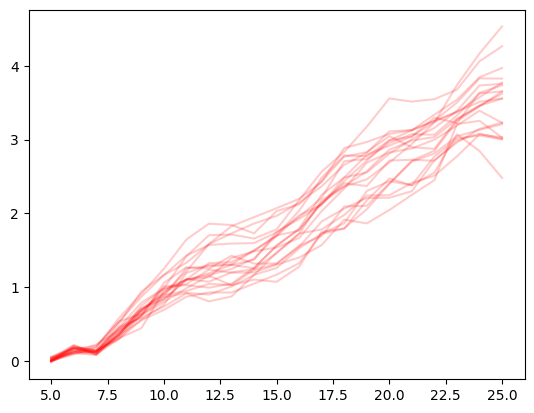

In [20]:
sdd.plot(legend=False, style='-r', alpha=.2)